The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Gráfico salvo como 'Images/WindSpeed.eps'


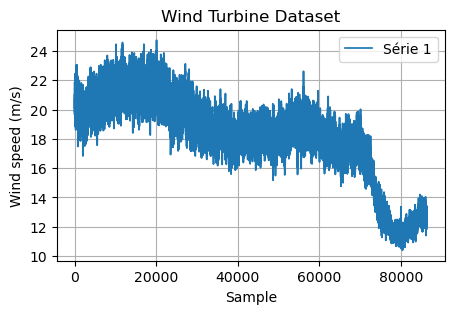

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from importlib import reload
from scipy import signal
from scipy.integrate import solve_ivp
from scipy.signal import cont2discrete, tf2ss
import math
from _GraphUtils import *

path = r'params2.csv'
params = pd.read_csv(path)
params = dict(zip(params['Parameter'], params['Value']))

path2 = r'Datasets/WindSpeed_V1.csv'
df = pd.read_csv(path2)  
v = df.iloc[:,0].values + 1
v = np.sqrt(np.flip(v) )*4*1.5
PlotSeries(y_arrays=[v[:]],w=5,h=3,yname=r'Wind speed (m/s)', xname='Sample', title='Wind Turbine Dataset',pltly=False, file_name=r'Images/WindSpeed.eps',save=True,lw=1.25)

In [42]:
def Cp_calc(LAMBDA=0, PHI=0):
    PHI = PHI*180/np.pi
    path = r'TSRxCPxPSI.csv'
    df = pd.read_csv(path)
    angles = np.arange(-5,6,1)
    TSR = df.iloc[:,0]
    diff1 = np.abs(TSR - LAMBDA)
    diff2 = np.abs(angles - PHI)
    id1 = np.argmin(diff1)
    id2 = np.argmin(diff2)+1

    return df.iloc[id1,id2]

def Cq_calc(LAMBDA=0, PHI=0):
    PHI = PHI*180/np.pi
    path = r'Cq.csv'
    df = pd.read_csv(path)
    angles = np.arange(-5,6,1)
    TSR = df.iloc[:,0]
    diff1 = np.abs(TSR - LAMBDA)
    diff2 = np.abs(angles - PHI)
    id1 = np.argmin(diff1)
    id2 = np.argmin(diff2)+1

    return df.iloc[id1,id2]

class HAWT:
    def __init__(self, **params):

        self.Area =params['Area']
        self.B_dt =params['B_dt']
        self.B_r =params['B_r']
        self.B_g =params['B_g']
        self.CP_max =params['CP_max']
        self.ETA_dt =params['ETA_dt']
        self.ETA_gc =params['ETA_gc']
        self.J_r =params['J_r']
        self.J_g =params['J_g']
        self.K_dt =params['K_dt']
        self.k_i =params['k_i']
        self.k_p =params['k_p']
        self.λ_opt =params['LAMBDA_opt']
        self.N_g =params['N_g']
        self.OMEGA_n =params['OMEGA_n']
        self.OMEGA_nom =params['OMEGA_nom']
        self.OMEGA_var =params['OMEGA_var']
        self.PHI_opt = params['PHI_opt']
        self.P_r =params['P_r']
        self.PI =params['PI']
        self.R =params['R']
        self.RHO =params['RHO']
        self.T_s = params['T_s']
        self.ZETA = params['ZETA']
        
        self.U = None
        self.X  = np.array([0,0,0])
        self.dX = np.array([0,0,0]) 
        self.e = np.array([0])
        self.P_g = np.array([0]) 
        self.K_mppt = np.array([])  
        self.P_d = np.array([0]) 
        self.mode = np.array([])     
        self.ctrl_mode = 'mode1'
        self.φ_m = np.array([0])
        self.dφ_m = np.array([0])
        self.φ_ref = np.array([0]) 
        self.ω_r = np.array([0])   
        self.ω_g = np.array([0])
        self.θ_s = np.array([0]) 
        self.τ_g = np.array([0])
        self.τ_r = np.array([0])  
        self.n = 0

    def set_state(self, X):
        self.X = X.flatten()

    def TAUr_(self, ω_r, φ_m, v):
        
        λ = ω_r*self.R/v
        C_p = Cq_calc(λ, φ_m)
        #τ_r = self.RHO*self.Area*C_p*(v**3)/(2*ω_r)
        τ_r = self.RHO*self.PI*(self.R**3)*C_p*(v**2)/(2)
        self.ω_r = np.append(self.ω_r, ω_r)
        self.τ_r = np.append(self.τ_r, τ_r)
        return τ_r

    def TAUg_(self, ω_g, φ_m, u_k=0):
        change = False
        
        λ = self.λ_opt + u_k
        C_p = Cp_calc(λ,0)
        K_mppt = self.RHO*self.Area*(self.R**3)*C_p/(2*(λ**3)*self.N_g)
        τ_g = K_mppt*((ω_g/self.N_g)**2)
        P_g = self.ETA_gc*ω_g*τ_g

        if self.ctrl_mode == 'mode1':
            #print('Append 1')
            #self.mode = np.append(self.mode,1)
            self.K_mppt = np.append(self.K_mppt,K_mppt)
            φ_ref = 0
            #self.PHI_ref = 0

        if self.ctrl_mode == 'mode2':
            #print(self.ctrl_mode)
            #self.mode = np.append(self.mode,2)
            τ_g = self.P_r/(self.ETA_gc*ω_g)
            #P_g = self.ETA_gc*ω_g*τ_g
            #print('pg:', P_g)
            e = ω_g - self.OMEGA_nom
            #φ_ref = self.φ_ref[-1] + self.k_p*e + (self.k_i*self.T_s - self.k_p)*self.e[-1]
            φ_ref = self.φ_ref[-1] + self.k_p*(e-self.e[-1]) + self.k_i*self.T_s*self.e[-1]
            #φ_ref = self.φ_ref[-1] + self.k_p*(e-self.e[-1]) + self.k_i*0.01*self.e[-1]
            self.e = np.append(self.e, e)
            self.K_mppt = np.append(self.K_mppt,0)
            #self.PHI_ref = φ_ref
            
        
        #if len(self.φ_ref) == 0:
        #    φ_ref =0
        #print(φ_ref)
        
        #print(self.ctrl_mode, self.mode[-1], φ_ref)
        self.φ_ref = np.append(self.φ_ref, φ_ref)

        change = False
        
        if self.ctrl_mode == 'mode1':
            self.mode = np.append(self.mode,1)
            if self.P_g[-1]>=self.P_r or self.ω_g[-1] >= self.OMEGA_nom:
                self.ctrl_mode = 'mode2'
                change = True
        if not change:
            if self.ctrl_mode == 'mode2':
                self.mode = np.append(self.mode,2)
                if self.ω_g[-1] < self.OMEGA_nom - self.OMEGA_var:
                    self.ctrl_mode = 'mode1'

        self.ω_g = np.append(self.ω_g, ω_g)
        self.φ_m = np.append(self.φ_m, φ_m)
        self.τ_g = np.append(self.τ_g, τ_g)
        return τ_g
    
    """ def switch_ctrl(self):
        change = False
        if self.ctrl_mode == 'mode1':
            self.mode = np.append(self.mode,1)
            if self.P_g[-1]>=self.P_r or self.ω_g[-1] >= self.OMEGA_nom:
                self.ctrl_mode = 'mode2'
                change = True
        if not change:
            if self.ctrl_mode == 'mode2':
                self.mode = np.append(self.mode,2)
                if self.ω_g[-1] < self.OMEGA_nom - self.OMEGA_var:
                    self.ctrl_mode = 'mode1' """

    
    def dynamics(self, t, X, U):

        A11 = -(self.B_dt+self.B_r)/self.J_r
        A12 = self.B_dt/(self.N_g*self.J_r)
        A13 = -self.K_dt/self.J_r
        A21 = (self.B_dt*self.ETA_dt)/(self.N_g*self.J_g)
        A22 = -(((self.B_dt*self.ETA_dt)/(self.N_g**2))+self.B_g)*(1/self.J_g)
        A23 = (self.K_dt*self.ETA_dt)/(self.N_g*self.J_g)
        A32 = -1/self.N_g
        A54 = -(self.OMEGA_n**2)
        A55 = -(2*self.ZETA*self.OMEGA_n)
        B11 = 1/self.J_r
        B22 = -1/self.J_g
        B53 = (self.OMEGA_n**2)
        
        A = np.array([[A11, A12, A13,   0,   0],
                      [A21, A22, A23,   0,   0],
                      [  1, A32,   0,   0,   0],
                      [  0,   0,   0,   0,   1],
                      [  0,   0,   0, A54, A55]])
        
        B = np.array([[B11,   0,   0],
                      [  0, B22,   0],
                      [  0,   0,   0],
                      [  0,   0,   0],
                      [  0,   0, B53]])

        n_states = A.shape[0]
        n_inputs = B.shape[1]
        C = np.eye(n_states)
        D = np.zeros((n_states, n_inputs))

        sys_continuous = (A, B, C, D)
        sys_discrete = signal.cont2discrete(sys_continuous, dt=self.T_s, method='backward_diff')
        
        Ad = sys_discrete[0]
        Bd = sys_discrete[1]

        dX = (Ad@X.reshape(-1,1))+(Bd@U.reshape(-1,1))
        self.dX = dX.flatten()
        return dX.flatten()
    
    def compute_input(self, X, v, u_k=0):

        ω_r, ω_g, θ_s, φ_m, dφ_m = X[0], X[1], X[2], X[3], X[4]
        τ_r = self.TAUr_(ω_r, φ_m, v)
        τ_g = self.TAUg_(ω_g, φ_m, u_k)
        φ_ref = self.φ_ref[-1]
        self.U = np.array([τ_r,τ_g,φ_ref])
        return self.U
    
    def iterate(self, U):

        dt = self.T_s
        X = self.dynamics(dt,self.X,U)
        self.X = X
        return self.X
    
    def compute_output(self):
        X = self.X
        ω_r, ω_g, θ_s, φ_m, dφ_m = X[0], X[1], X[2], X[3], X[4]
        τ_r, τ_g = self.U[0], self.U[1]
        η_gc = self.ETA_gc
        P_g = ω_g*η_gc*τ_g
        #print('ω_g:',ω_g)
        self.P_g = np.append(self.P_g, P_g)
        self.θ_s = np.append(self.θ_s, θ_s)
        self.dφ_m = np.append(self.dφ_m, dφ_m)


In [52]:
hawt = HAWT(**params)
X=np.array([0.1,0.1*hawt.N_g,0,0,0])
hawt.set_state(X)
e = 30000
for i,v_ in enumerate(v[:]):
    #print(i,'-',X[-2:])
    #hawt.switch_ctrl()
    U = hawt.compute_input(X,v=v_,u_k=0)
    X = hawt.iterate(U) #dt=0.1
    hawt.compute_output()


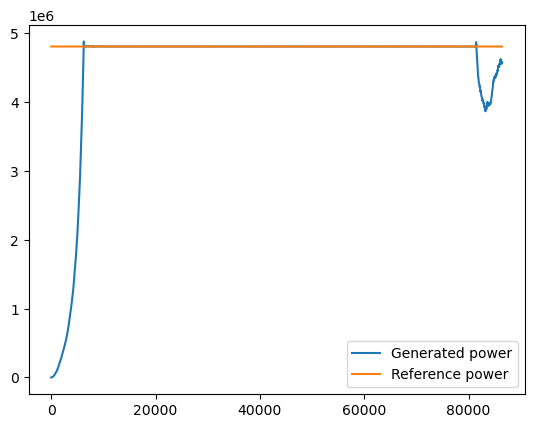

In [53]:
y1 = hawt.P_g
x = np.arange(len(y1))
y2 = np.array([hawt.P_r for i in range(len(x))])
plt.plot(x,y1, label='Generated power')
plt.plot(x,y2, label='Reference power')
plt.legend()
plt.show()

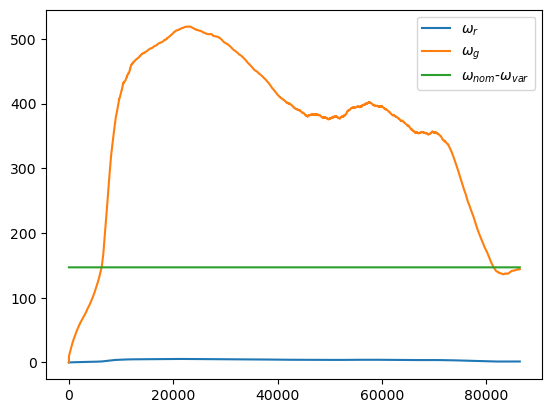

In [54]:
y1 = hawt.ω_r
y2 = hawt.ω_g
y3 = np.array([hawt.OMEGA_nom-hawt.OMEGA_var for i in range(len(x))])
x = np.arange(len(y1))

plt.plot(x,y1, label=r'$\omega_r$')
plt.plot(x,y2, label=r'$\omega_g$')
plt.plot(x,y3, label=r'$\omega_{nom}$-$\omega_{var}$')
plt.legend()
plt.show()

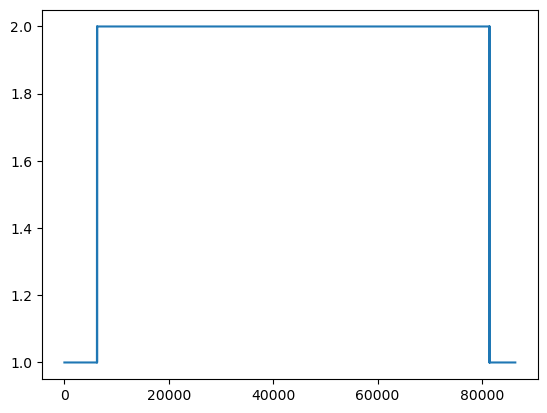

In [55]:
y = hawt.mode[:]
x = np.arange(len(y))
y2 = np.array([hawt.OMEGA_nom for i in range(len(x))])
#plt.plot(x,y2)
plt.plot(x,y)

In [5]:
hawt.mode[:]

array([1., 1., 1., ..., 2., 2., 2.])

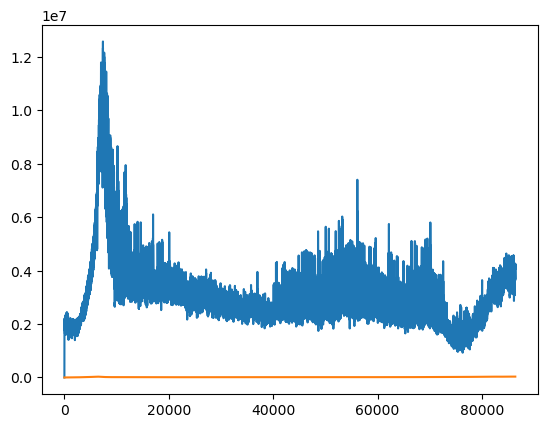

In [56]:
y1 = hawt.τ_r
x = np.arange(len(y1))
y2 = hawt.τ_g
plt.plot(x,y1)
plt.plot(x,y2)

In [203]:
print(len(hawt.ω_r))
print(len(hawt.ω_g))
print(len(hawt.θ_s))
print(len(hawt.φ_m))
print(len(hawt.dφ_m))
print(len(hawt.φ_ref))

6260
6260
6260
6260
6260
6260


In [21]:
for i in range(6240,6260):
    print(hawt.P_g[i],hawt.P_r, hawt.ctrl_mode, hawt.mode[i])
    print(hawt.ω_g[i], hawt.OMEGA_nom)
    #print(hawt.ω_g[i], hawt.OMEGA_nom-hawt.OMEGA_var)
    print(hawt.φ_ref[-1])
    print('-----------')

4819988.747710483 4800000.0 mode1 1.0
146.49777258303428 162.0
0.0
-----------
4800911.68169707 4800000.0 mode1 2.0
146.5254159465864 162.0
0.0
-----------
4825206.34213468 4800000.0 mode1 1.0
146.55324605906014 162.0
0.0
-----------
4800690.405463222 4800000.0 mode1 2.0
146.5730034470067 162.0
0.0
-----------
4829019.278320329 4800000.0 mode1 1.0
146.59408569749434 162.0
0.0
-----------
4800500.145668299 4800000.0 mode1 2.0
146.60710652017937 162.0
0.0
-----------
4831643.699200479 4800000.0 mode1 1.0
146.6223825429435 162.0
0.0
-----------
4800389.749953341 4800000.0 mode1 2.0
146.6301698104385 162.0
0.0
-----------
4833545.199442505 4800000.0 mode1 1.0
146.64207587332223 162.0
0.0
-----------
4800426.703544979 4800000.0 mode1 2.0
146.64848000530722 162.0
0.0
-----------
4835522.075884723 4800000.0 mode1 1.0
146.66151655244974 162.0
0.0
-----------
4800543.775798048 4800000.0 mode1 2.0
146.6695666874297 162.0
0.0
-----------
4838102.164071824 4800000.0 mode1 1.0
146.68618238757026 16

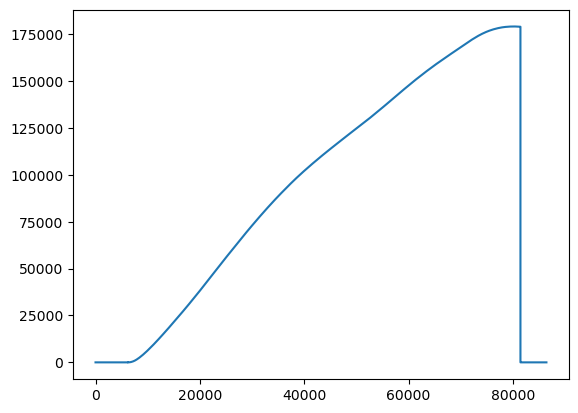

In [57]:
plt.plot(hawt.φ_ref[:])

In [58]:
len(hawt.P_g)

86401

In [139]:
U = hawt.compute_input(X,v=v_,u_k=0)
X = hawt.iterate(U) #dt=0.1
hawt.compute_output()